In [1]:
import cv2
import math
import urllib
import time
import numpy as np
import geopandas as gpd
from PIL import Image
from io import BytesIO
from pathlib import Path
from math import pi
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchinfo import summary


Point = namedtuple('Point', ['lon', 'lat'])
RADIUS = 6378137 # Радиус Земли
EQUATOR = 40075016.685578488 # Длина Экватора
DELAY = 0.03
E = 0.0818191908426 # Эксцентриситет
E2 = 0.00669437999014 # Эксцентриситет в квадрате
zoom = 20


def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 1 << zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return xtile, ytile + 924


def concat_3x3_imgs(imgs):
    assert 3 == len(imgs), print(len(imgs))
    assert 3 == len(imgs[0]), len(imgs[0])
    img = imgs[0][0]
    width, height, channels = img.shape
    new_im = Image.new('RGB', (width * 3, height * 3))
    for i in range(3):
        for j in range(3):
            img = Image.frombytes(mode='RGB', size=(width, height), data=imgs[i][j])
            new_im.paste(img, box=(width * i, height * j))
    return new_im


def create_3x3_tile(x, y, zoom=20):
    imgs = []
    for idx_x in [x - 1, x, x + 1]:
        for idx_y in [y - 1, y, y + 1]:
             imgs.append(get_tile(idx_x, idx_y, zoom))
    imgs = np.array(imgs)
    imgs = imgs.reshape(3, 3, 256, 256, 3)
    img_3x3 = concat_3x3_imgs(imgs)
    return img_3x3


def create_3x3_tiles_from_sqlite_chunk(path_to_chunk: Path, imgs_save_path: Path):
    try:
        con = sqlite3.connect(path_to_chunk)
        cur = con.cursor()
        cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table' ORDER BY name;")
        res = cur.execute('select min(x), max(x), min(y), max(y) from t')
    except:
        con.close()
        return

    from_x, to_x, from_y, to_y = res.fetchone()

    imgs_save_path.mkdir(exist_ok=True)

    for x in range(from_x, to_x - 1):
        for y in range(from_y, to_y - 1):
            res = cur.execute(f"""select b from t where 
                                t.x in ({x}, {x + 1}, {x + 2}) 
                                and 
                                t.y in ({y}, {y + 1}, {y + 2})""")
            imgs = res.fetchall()
            imgs = np.array(imgs)
            imgs = imgs.reshape((3,3))
            img_3x3 = concat_3x3_imgs(imgs)
            img_name = Path(f'{x + 1}_{y + 1}.jpg')
            img_3x3.save(imgs_save_path / img_name)
    con.close()


def get_tile(x, y, zoom=20):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    time.sleep(DELAY)
    url = f'https://core-sat.maps.yandex.net/tiles?l=sat&v=3.1079.0&x={x}&y={y}&z={zoom}&scale=2&lang=ru_RU'
    # print(url)
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

def create_train_data(tile_coord, save_to):
    save_to = Path(save_to)
    save_to.mkdir(exist_ok=True, parents=True)
    df = gpd.read_file(tile_coord)
    train_points = df.geometry
    for point in tqdm(train_points):
        lat, lon = point.coords[0]
        x, y = deg2num(lon, lat, 20)
        img = create_3x3_tile(x, y)
        img.save(save_to / Path(f'{x}_{y}.png'))


# VISUALIZING DATASET
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image (Pascal_VOC format bboxes)"""
    x_min, y_min, x_max, y_max = map(int, bbox)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize_img(image, bboxes, category_ids, category_id_to_name):  
    #if not isinstance(image, np.array):
    image = np.array(torch.permute(image, (1, 2, 0)))
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        print(bbox)
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow((img).astype(np.uint8))


def visualize_batch(batch, labels):
    if len(np.shape(batch)) == 4:
        for img, t in zip(batch, labels):
            visualize_img(img, t['boxes'], t['labels'], '0')
    else:
        visualize_img(batch, labels['boxes'], labels['labels'], '0')
    

In [2]:
# весь район
top_left = '55.831263, 37.744514'
bot_right = '55.820683, 37.772452'

# только площадка
top_left = '55.827908, 37.753342'
bot_right = '55.827399, 37.753942'

top_left = Point(float(top_left.split(', ')[0]), float(top_left.split(', ')[1]))
bot_right = Point(float(bot_right.split(', ')[0]), float(bot_right.split(', ')[1]))

current_coord = '55.698890, 37.537845'
# 634253 328340
cur_point = Point(float(current_coord.split(', ')[0]), float(current_coord.split(', ')[1]))

In [3]:
BASKET_COURT_FN = Path('../data/basketball court_points-2.geojson')
df = gpd.read_file(BASKET_COURT_FN)

In [4]:
train_points = df.geometry

In [5]:
import torch
import albumentations as A

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from xml.etree.ElementTree import parse

/Users/eugk/Desktop/Pet_projects/basket_court_recognition/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
class CourtDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.mask_labels = ['basket_court']
        self.transform = transform
        self.target_transform = target_transform

        self.imgs = sorted(list(Path(img_dir).glob('[!.DS_Store]*')))
        self.masks = sorted(list(Path(mask_dir).glob('[!.DS_Store]*')))
        assert len(self.imgs) == len(self.imgs), \
            f'The number of imgs ({len(self.imgs)}) and masks ({len(self.imgs)}) does not match' 

         # Add for data augmentation.
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p = 0.5),
            A.RandomBrightnessContrast(p = 0.5),
            #A.augmentations.geometric.resize.LongestMaxSize(max_size=256)
         ], bbox_params = bbox_params)
    

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = Image.open(self.imgs[idx]).convert('RGB')
        image = np.array(image)
        
        parser = parse(self.masks[idx])
        mask_labels = ['basket_court']
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox')
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [float(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                #labels.append(label)
                labels.append(1)
        
        transformed = self.transform(image=image, bboxes=boxes, class_labels=labels)
        image = torch.tensor(transformed['image'], dtype = torch.float32)
        # first chanel is image deep
        image = torch.permute(image, (2, 0, 1))
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float16)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)

        # Add for estimation of mean Average Precisions.
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}
        # image.to(device)
        # target.to(divice)
        return image, target

#torch.permute(torch.Tensor(x), (0, 3, 1, 2))

In [9]:
train_dir = '../data/train_data/'
mask_dir = '../data/train_data_mask/'

#transform = 

dt = CourtDataset(train_dir, mask_dir)

In [10]:
train, val, test = torch.utils.data.random_split(dataset = dt, 
                                                 lengths = [0.7, 0.2, 0.1], 
                                                 generator = torch.Generator().manual_seed(4))

In [11]:
len(train)

48

In [24]:
def collate_fn(batch):
    return list(zip(* batch))

train_loader = DataLoader(
    train, 
    batch_size=5, 
    collate_fn=collate_fn,
    pin_memory=True,
    shuffle=True,
    #pin_memory_device='mps'
)

val_loader = DataLoader(
    val, 
    batch_size=1, 
    collate_fn=collate_fn,
    pin_memory=True,
    #pin_memory_device='mps'
)

x, t = next(iter(train_loader))

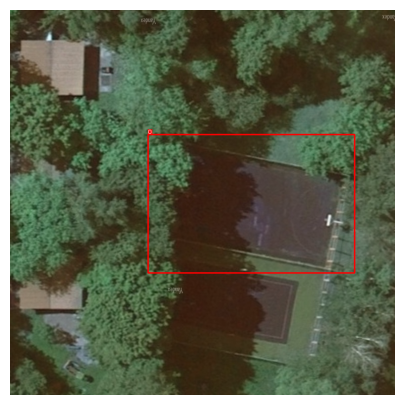

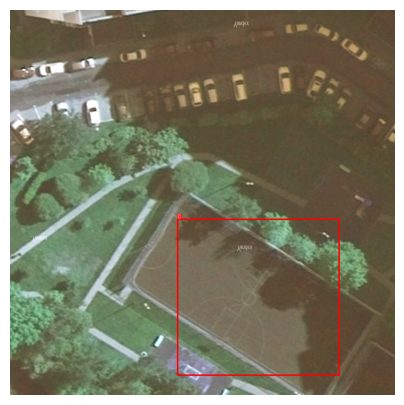

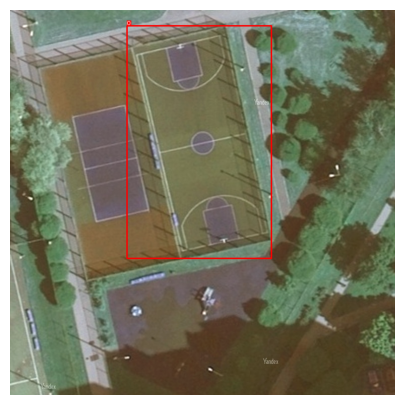

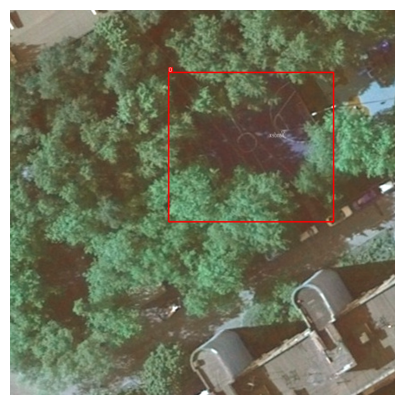

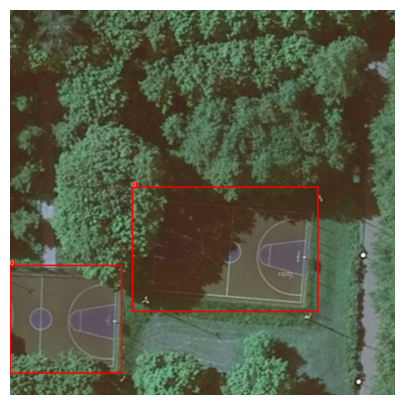

In [25]:


visualize_batch(x, t)

In [15]:
import math
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [16]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [17]:
def visualize_img(image, bboxes, category_ids, category_id_to_name):  
    #if not isinstance(image, np.array):
    image = np.array(torch.permute(image, (1, 2, 0)))
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        #print(bbox, category_id_to_name, category_id)
        #class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, category_id_to_name)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow((img).astype(np.uint8))


def visualize_batch(batch, labels):
    if len(np.shape(batch)) == 4:
        for img, t in zip(batch, labels):
            visualize_img(img, t['boxes'], t['labels'], '0')
    else:
        visualize_img(batch, labels['boxes'], labels['labels'], '0')

In [26]:
#from engine import train_one_epoch, evaluate
device = torch.device('mps')
train_on_device = False
num_classes = 2

@torch.no_grad()
def evaluate_loss(model, data_loader, train_on_device, device):
    val_loss = 0
    model.train()
    for images, targets in data_loader:
        if train_on_device:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        # loss_dict_reduced = utils.reduce_dict(loss_dict)
        # losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        val_loss += sum(loss for loss in loss_dict.values())
  
    validation_loss = val_loss/ len(data_loader)    
    return validation_loss


# Step 1: Initialize model with the best available weights
weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1
model = fasterrcnn_mobilenet_v3_large_fpn(box_score_thresh=0.9)#, weights=weights)
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
# Step 2: replace lact classification layer

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
if train_on_device:
    model.to(device)
#summary(model)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 5
itr = 1
loss_batch = 0
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    # train_one_epoch(model, optimizer, data_loader, device, train_loader, print_freq=10)
    
    for images, targets in train_loader:
        
        if train_on_device:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        
        with torch.no_grad():
            model.eval()
            #visualize_batch(images, model(images))
            #print(model(images))
        model.train()
        loss_dict = model(images, targets)
        #optimizer(model, loss_dict)
        #print(loss_dict) 
        losses = sum(loss for loss in loss_dict.values())
        # print(losses)         
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            print(loss_dict)
            sys.exit(1)
        loss_batch += losses
        
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 200)
        optimizer.step()
        
        if itr % 5 == 0:
            print(f"Iteration #{itr} loss: {losses}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    train_loss = loss_batch / len(train_loader.dataset)
    print(f'\nEpoch #{epoch + 1}. Train loss: {loss_batch}')
    avg_loss = evaluate_loss(model, val_loader, train_on_device, device)
    print(f'LOSS validation dataset: {avg_loss}\n')

print("That's it!")

#res = model_fasterrcnn(x, t)

Iteration #5 loss: 11.284993171691895
Iteration #10 loss: 13.700278282165527

Epoch #1. Train loss: 11635.0849609375
LOSS validation dataset: 99485.015625

Iteration #15 loss: 4.371732234954834
Iteration #20 loss: 583.8965454101562

Epoch #2. Train loss: 250584.359375
LOSS validation dataset: 12895.771484375

Iteration #25 loss: 25.26078224182129
Iteration #30 loss: 488.11737060546875

Epoch #3. Train loss: 373627.34375
LOSS validation dataset: 1.1964834928512573

Iteration #35 loss: 21.045034408569336
Iteration #40 loss: 0.3936232626438141

Epoch #4. Train loss: 373661.25
LOSS validation dataset: 0.37005099654197693

Iteration #45 loss: 0.6004842519760132
Iteration #50 loss: 0.3864980638027191

Epoch #5. Train loss: 373671.84375
LOSS validation dataset: 0.6733801960945129

That's it!


In [27]:
model.train()
with torch.no_grad():
    print(model(images, t))

{'loss_classifier': tensor(0.1957), 'loss_box_reg': tensor(0.0962), 'loss_objectness': tensor(0.1948), 'loss_rpn_box_reg': tensor(0.0560)}


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


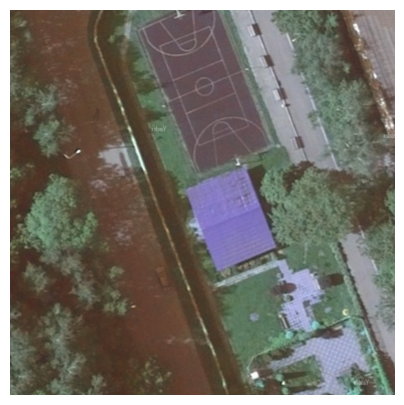

In [42]:
model.eval()
images, t = next(iter(val_loader))
print(model(images))
visualize_batch(images, model(images))

In [ ]:
model(x, t)

In [ ]:
t

In [67]:

model(x)

[{'boxes': tensor([[  0.0000,   0.0000, 768.0000, 768.0000],
          [  0.0000,   0.0000, 300.6375, 768.0000]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([1.0000, 1.0000], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[  0.0000,   0.0000, 768.0000, 768.0000],
          [  0.0000,   0.0000, 768.0000,   7.5368],
          [  0.0000,   0.0000, 768.0000, 110.4882],
          [  0.0000,   0.0000, 768.0000,  40.0626]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([1.0000, 0.9999, 0.9998, 0.9994], grad_fn=<IndexBackward0>)}]